# **Clasificación Automática de Tickets con NLP**

## **Integrantes**
* Wilder Serdan (wserdan@gmail.com)
* Oscar Ramirez (oscar.ramirez.guachalla@gmail.com)
* Ruth Daniela Villalobos (ruthdanivillalobos@gmail.com)

## **Descripción del Problema** 

Clasificar las quejas (complaints) de los clientes en función de los productos/servicios. Segregando estos tickets en sus categorías relevantes y, por lo tanto, ayudar en la resolución rápida del problema.

Se realizará el modelado de temas en los datos <b>.json</b> proporcionados por la empresa. Dado que estos datos no están etiquetados, debe aplicar NMF para analizar patrones y clasificar los tickets en los siguientes cinco grupos según sus productos/servicios:

* Tarjetas de Credito / Tarjetas Prepagadas (Credit card / Prepaid Card)

* Servicios de Cuentas de Banco (Bank account services)

* Reportes de Robos (Theft/Dispute reporting)

* Prestamos Hipotecarios y Otros Prestamos (Mortgages/loans)

* Otros

Con la ayuda del modelado de temas, se asignará cada ticket a su respectivo departamento/categoría. Luego se usarán estos datos para entrenar cualquier modelo supervisado, como regresión logística, árbol de decisión o bosque aleatorio. Usando este modelo entrenado, se clasificará cualquier nuevo ticket de soporte de quejas de clientes en su departamento correspondiente.

## **Flujo de Trabajo**
1. Setup e Importación de Librerias
2. Cargado de datos
3. Procesamiento de texto
4. Análisis Exploratorio de Datos (EDA)
5. Extracción de características
6. Topic modeling usando NMF
7. Modelo supervisado para predecir cualquier queja nueva a los temas relevantes
8. Training, evaluación e inferencia de modelos
9. Conclusiones

# **1. Setup e Importación de Librerías**

In [1]:
## Instalación de SpaCy and en_core_web_sm
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install textblob

  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: colorama
    Found existing installation: colorama 0.4.4
    Uninstalling colorama-0.4.4:
      Successfully uninstalled colorama-0.4.4
  Attempting uninstall: smart-open
    Found existing installation: smart-open 5.1.0
    Uninstalling smart-open-5.1.0:
      Successfully uninstalled smart-open-5.1.0
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import json
import numpy as np
import pandas as pd
import re, string

# Importar librerias NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Importar librerias Spacy
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint
from textblob import TextBlob

# Borrado de Warnings 
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Descargar Recursos NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to C:\Users\Dani
[nltk_data]     Villalobos\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to C:\Users\Dani
[nltk_data]     Villalobos\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to C:\Users\Dani
[nltk_data]     Villalobos\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to C:\Users\Dani
[nltk_data]     Villalobos\AppData\Roaming\nltk_data...


True

# **2. Cargado de Datos**

De JSON a un dataframe.

In [4]:
# Opening JSON file 
f = open("complaints.json") # Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Preparación de los Datos

In [5]:
# Estudiando el Dataframe para entender los datos
df.head(3)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided


In [6]:
#Nombres de columnas
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [7]:
# Asignando nombres de columnas
# La columna relevante para el análisis es el "complaint"
df = df[['_source.complaint_what_happened']]#,'_source.product','_source.sub_product',]]
df = df.rename(columns={'_source.complaint_what_happened': 'complaint'})#, '_source.product': 'category','_source.sub_product': 'sub_category'})
df.head()

,complaint
0,
1,Good morning my name is XXXX XXXX and I apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...
3,
4,


In [8]:
# nueva columna
df["complaint"].isnull().sum()

0

In [9]:
# Nan en espacios blancos
len(df[df['complaint']==''])

57241

In [10]:
df[df['complaint']==''] = np.nan
df.complaint.isnull().sum()

57241

In [11]:
# Borrar todas las columnas nulas
df = df[~df['complaint'].isnull()]
df.complaint.isnull().sum()

0

# **3. Procesamiento de Texto**

Pasos tomados en cuenta:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [12]:
# Nueva celda
# Convertir la columna complaint_what_happened a string
df['complaint'] = df['complaint'].astype(str)

In [13]:
# Limpiando texto
def eliminarTexto(s):
    s = s.lower()  # Convertimos a minusculas
    s = re.sub('\[.*\]','', s).strip() # Removemos caracteres no necesarios (entre brackets)
    s = s.translate(str.maketrans('', '', string.punctuation)) # Eliminamos signos de puntuación
    s = re.sub('\S*\d\S*\s*','', s).strip()  # Removemos palabras que contienen numeros
    return s.strip()

In [14]:
df.complaint = df.complaint.apply(lambda x: eliminarTexto(x))
df.complaint.head()

1     good morning my name is xxxx xxxx and i apprec...
2     i upgraded my xxxx xxxx card in and was told b...
10    chase card was reported on however fraudulent ...
11    on while trying to book a xxxx  xxxx  ticket i...
14    my grand son give me check for i deposit it in...
Name: complaint, dtype: object

In [15]:
# Lemmatización de texto
stopwords = nlp.Defaults.stop_words
def lemmatizer(s):
    doc = nlp(s)
    x = [token.lemma_ for token in doc if not token.text in set(stopwords)]
    return ' '.join(x)

df['lemma'] =  df.complaint.apply(lambda x: lemmatizer(x))
df.head()

,complaint,lemma
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...


In [16]:
# Creando dataframe ('df_clean') solo con complaint y la lematización de complaint
df_clean = df[['complaint','lemma']]#,'category']]

In [17]:
df_clean

,complaint,lemma
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...
...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...
78311,i have had flawless credit for yrs ive had cha...,flawless credit yrs ve chase credit card cha...


In [18]:
# Transformamos a texto los campos que en una anterior corrida se reconocieron como float
df_clean[df_clean["lemma"].isna()]
df_clean['lemma'] = df_clean['lemma'].astype(str)

In [19]:
# Extracción de los tags POS 

def pos_tag(text):
   doc = nlp(text) 
   x = [token.text for token in doc if token.tag_ == "NN"]
   return ' '.join(x)

df_clean["complaint_POS_removed"] = df_clean["lemma"].apply(lambda x: pos_tag(x))

In [20]:
# El dataframe limpio debe ya tener complaint, lemmatized complaint y el complaint despues de borrar los POS.
df_clean

,complaint,lemma,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help bank service chase debt verificat...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,card agent upgrade anniversary date change age...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,chase card report application submit identity ...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,book ticket come offer ticket reward card info...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund bank account pa...
...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,credit card provider ask claim purchase protec...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,xxxx risk consumer year trust mobile banking t...
78311,i have had flawless credit for yrs ive had cha...,flawless credit yrs ve chase credit card cha...,credit yrs credit card chase freedom problem t...


# **4. Análisis Exploratorio de Datos (EDA).**

* Visualización de los datos según la longitud del carácteres 'Complaint'
* Encontrar las 40 palabras más usadas en los artículos.
* Encontrar los unigrams, bigrams y trigrams top por frecuencia a través de todos los compaints despues de procesar texto.

### **Visualización de los datos según la longitud del carácteres 'Complaint'**

(array([9.235e+03, 6.357e+03, 2.724e+03, 1.277e+03, 7.580e+02, 2.740e+02,
        1.500e+02, 7.100e+01, 6.300e+01, 3.900e+01, 3.700e+01, 1.300e+01,
        1.100e+01, 1.100e+01, 8.000e+00, 8.000e+00, 7.000e+00, 2.000e+00,
        3.000e+00, 3.000e+00, 7.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([    0. ,   248.5,   497. ,   745.5,   994. ,  1242.5,  1491. ,
         1739.5,  1988. ,  2236.5,  2485. ,  2733.5,  2982. ,  3230.5,
         3479. ,  3727.5,  3976. ,  4224.5,  4473. ,  4721.5,  4970. ,
         5218.5,  5467. ,  5715.5,  5964. ,  6212.5,  6461. ,  6709.5,
         6958. ,  7206.5,  7455. ,  7703.5,  7952. ,  8200.5,  8449. ,
         8697.5,  894

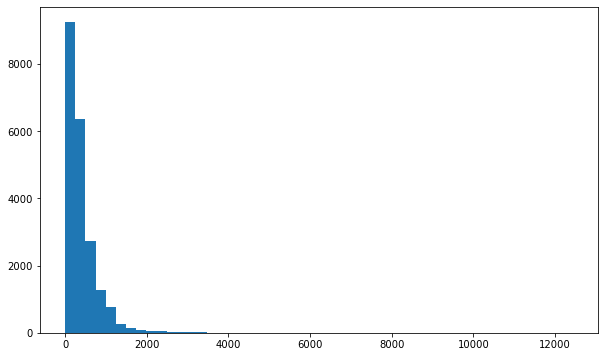

In [21]:
# Visualización de datos de acuerdo a Complaint
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean["complaint_POS_removed"]] 
plt.hist(doc_lens, bins = 50)

### **Encontrar las 40 palabras más usadas en los artículos.**

In [23]:
!pip install wordcloud

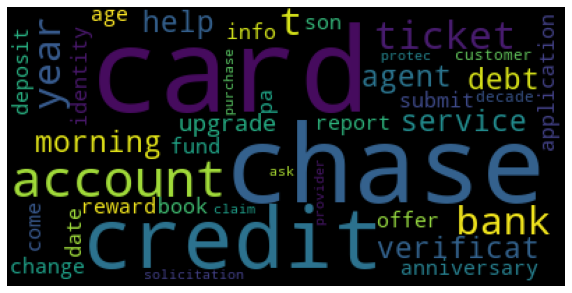

In [24]:
# Encontrar los top 40 palabras por frecuencia en todos los artículos despues de procesar el texto.

from wordcloud import WordCloud
maxwords=40
wordcloud = WordCloud(stopwords=stopwords,max_words=maxwords).generate(str(df_clean.complaint_POS_removed))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

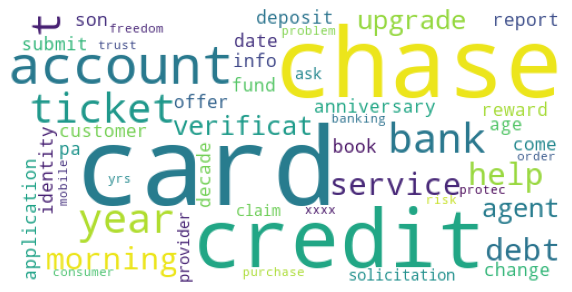

In [25]:
from PIL import Image
mask = np.array(Image.open("scream.png"))
mask[mask == 1] = 255

wordcloud = WordCloud(background_color = "white", stopwords = stopwords, max_words = 50, mask = mask).generate(str(df_clean.complaint_POS_removed))
print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

In [26]:
# Borrando -PRON- del texto
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

### **Encontrar los unigrams, bigrams y trigrams top por frecuencia a través de todos los compaints despues de procesar texto.**

In [27]:
#Encontrar los top 30 unigramas de frecuencia en el dataframe(df_clean). 

def xgrams(s, n=30, g=1):
  vec = CountVectorizer(stop_words='english', ngram_range=(g,g)).fit(s)
  bagofwords = vec.transform(s)
  suma = bagofwords.sum(axis=0)
  f = [(word, suma[0, index]) for word, index in vec.vocabulary_.items()]
  f = sorted(f, key = lambda x: x[1], reverse=True)
  return f[:n]

In [28]:
# Top 10 de palabras
top10uni = xgrams(df_clean['Complaint_clean'].values.astype('U'), 10, 1)
df_unigram = pd.DataFrame(top10uni, columns=['unigram', 'count'])
df_unigram

,unigram,count
0,chase,53415
1,account,40962
2,credit,33554
3,xxxx,31273
4,card,29835
5,payment,21064
6,bank,17034
7,time,15871
8,charge,15292
9,day,12831


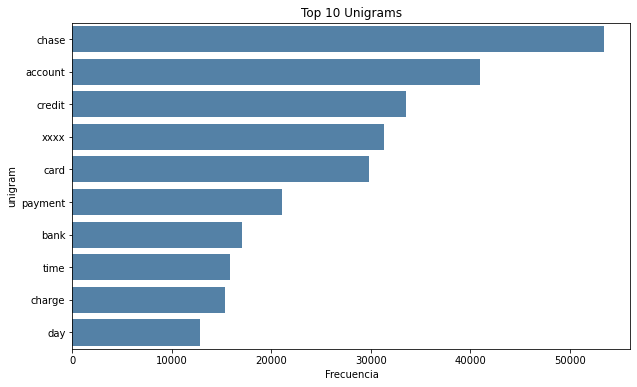

In [29]:
# Visualizamos los top 10 unigramas

plt.figure(figsize=[10,6])
sns.barplot(x=df_unigram['count'], y=df_unigram['unigram'],color='steelblue')
plt.xlabel("Frecuencia")
plt.title("Top 10 Unigrams")
plt.show()

In [30]:
# Top 10 palabras en el Bigram
top10bi = xgrams(df_clean['Complaint_clean'].values.astype('U'), 10, 2)
df_bigram = pd.DataFrame(top10bi, columns=['bigram', 'count'])
df_bigram

,bigram,count
0,credit card,12773
1,credit report,3893
2,chase credit,3070
3,customer service,2923
4,account chase,2432
5,chase bank,2119
6,check account,2113
7,chase account,2034
8,xxxx xxxx,1955
9,contact chase,1893


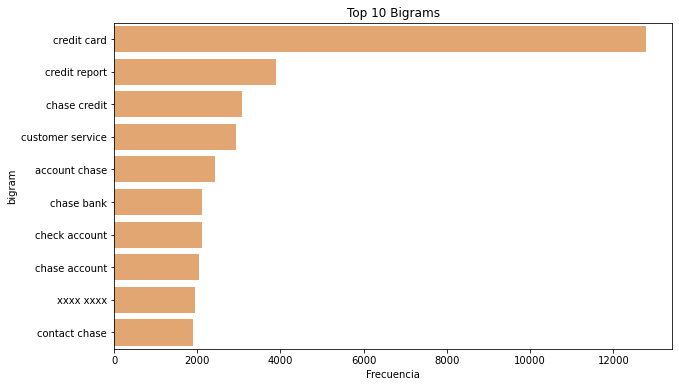

In [31]:
# Visualizamos los top 10 bigramas

plt.figure(figsize=[10,6])
sns.barplot(x=df_bigram['count'], y=df_bigram['bigram'],color='sandybrown')
plt.xlabel("Frecuencia")
plt.title("Top 10 Bigrams")
plt.show()

In [32]:
# Top 10 words in the Trigram frequency 
top10tri = xgrams(df_clean['Complaint_clean'].values.astype('U'), 10, 3)
df_trigram = pd.DataFrame(top10tri, columns=['trigram', 'count'])
df_trigram

,trigram,count
0,chase credit card,2196
1,credit card account,1050
2,credit card company,978
3,credit card chase,738
4,xxxx credit card,652
5,chase customer service,559
6,inquiry credit report,483
7,credit card credit,438
8,charge credit card,406
9,credit card xxxx,385


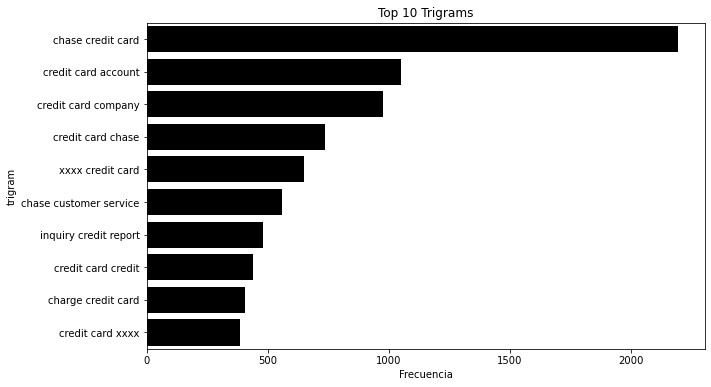

In [33]:
# Visualizamos los top 10 trigramas

plt.figure(figsize=[10,6])
sns.barplot(x=df_trigram['count'], y=df_trigram['trigram'],color='black')
plt.xlabel("Frecuencia")
plt.title("Top 10 Trigrams")
plt.show()

### **Los datos personales del cliente se han enmascarado en el conjunto de datos con xxxx. Eliminemos el texto enmascarado ya que no será de utilidad para nuestro análisis.**

In [34]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [35]:
# Todos los datos enmascarados de borraron
df_clean

,complaint,lemma,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help bank service chase debt verificat...,morning help bank service chase debt verificat...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,card agent upgrade anniversary date change age...,card agent upgrade anniversary date change age...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,chase card report application submit identity ...,chase card report application submit identity ...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,book ticket come offer ticket reward card info...,book ticket come offer ticket reward card info...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund bank account pa...,son deposit chase account fund bank account pa...
...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,credit card provider ask claim purchase protec...,credit card provider ask claim purchase protec...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,xxxx risk consumer year trust mobile banking t...,risk consumer year trust mobile banking tell ...
78311,i have had flawless credit for yrs ive had cha...,flawless credit yrs ve chase credit card cha...,credit yrs credit card chase freedom problem t...,credit yrs credit card chase freedom problem t...


# **5. Extracción de características**
Conversión de los textos sin procesar en una matriz de características TF-IDF


**max_df** se utiliza para eliminar términos que aparecen con demasiada frecuencia, también conocido como "palabras vacías específicas del corpus"
max_df = 0.95 significa "ignorar términos que aparecen en más del 95% de las quejas"

**min_df** se utiliza para eliminar términos que aparecen con poca frecuencia
min_df = 2 significa "ignorar términos que aparecen en menos de 2 denuncias"

In [36]:
# Inicializando TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

### **Matriz de términos de documento usando fit_transform**

El contenido de una matriz de términos de documento son tuplas de (complaint_id,token_id) puntuación tf-idf:
Las tuplas que no están tienen una puntuación tf-idf de 0

In [37]:
# Term Matrix transfiriendo las columnas de complaints en df_clean.
termMatrix = tfidf.fit_transform(df_clean['Complaint_clean'])

# **6. Topic Modelling usando NMF**

Non-Negative Matrix Factorization (NMF) es una técnica no supervisada, por lo que no hay etiquetas de temas en los que se entrenará el modelo. La forma en que funciona es que NMF descompone (o factoriza) vectores de alta dimensión en una representación de menor dimensión. Estos vectores de menor dimensión no son negativos, lo que también significa que sus coeficientes no son negativos.

En el presente trabajo se realizó lo siguiente:

* Encontrar el mejor número de clústeres
* Aplicar el mejor número para crear grupos de palabras
* Inspeccionar y validar la corrección de cada grupo frente a las quejas
* Correjir las etiquetas
* Asignar los grupos a temas/nombres de grupos
* Encontrar el mejor número de clústeres
* Aplicar el mejor número para crear grupos de palabras
* Inspeccionar y validar la corrección de cada grupo frente a las quejas (Complaints)
* Correr las etiquetas 
* Mapear el grupo de nombres de topicos/clusters

In [38]:
from sklearn.decomposition import NMF

## **6.1 Manual Topic Modeling**
Debe adoptar el enfoque de prueba y error para encontrar la mejor cantidad de topicos para su modelo NMF.

El único parámetro que se requiere es el número de componentes, es decir, el número de topicos que queremos. Este es el paso más crucial en todo el proceso de modelado de topicos y afectará en gran medida la calidad de sus topicos finales.

In [39]:
# Cargado de nmf_model con n_components 
num_topics = 5 
# Mantener random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)#write your code here

In [41]:
nmf_model.fit(termMatrix)
len(tfidf.get_feature_names())
H = nmf_model.components_   

In [42]:
# Top 15 palabras de cada uno de los topics
words = np.array(tfidf.get_feature_names())
topicos = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Grupo {i}' for i in range(num_topics)],columns=[f'{i}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topicos.iloc[i] = words[ix]

topicos.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Grupo 0,account,check,money,bank,deposit,chase,fund,day,branch,transfer,number,business,transaction,customer,claim
Grupo 1,card,credit,chase,balance,account,score,limit,year,purchase,point,month,application,service,reason,time
Grupo 2,payment,loan,mortgage,chase,month,modification,time,home,pay,year,rate,balance,property,statement,date
Grupo 3,report,inquiry,credit,information,company,reporting,debt,account,file,identity,remove,dispute,theft,score,letter
Grupo 4,charge,dispute,fee,chase,transaction,merchant,claim,purchase,refund,fraud,service,email,time,contact,statement


In [43]:
# Crear el mejor topic para cada complaint en terminos de integer value 0,1,2,3 & 4
bestTopics = nmf_model.transform(termMatrix)


In [44]:
# Asignar el mejor topic a cada uno de los complaints en Topic Column
df_clean['Topic'] = bestTopics.argmax(axis=1)

In [45]:
df_clean.head()

,complaint,lemma,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help bank service chase debt verificat...,morning help bank service chase debt verificat...,0
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,card agent upgrade anniversary date change age...,card agent upgrade anniversary date change age...,1
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,chase card report application submit identity ...,chase card report application submit identity ...,3
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,book ticket come offer ticket reward card info...,book ticket come offer ticket reward card info...,3
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund bank account pa...,son deposit chase account fund bank account pa...,0


In [46]:
# Imprimir los 5 Complaint para casa Topic
df_clean_5first=df_clean.groupby('Topic').head(5)
df_clean_5first.sort_values('Topic').head(25)

,complaint,lemma,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help bank service chase debt verificat...,morning help bank service chase debt verificat...,0
24,mishandling of this account by chase auto and ...,mishandle account chase auto xxxx,mishandle account chase auto xxxx,mishandle account chase auto,0
17,with out notice jp morgan chase restricted my ...,notice jp morgan chase restrict account debit ...,account debit card branch customer service rep...,account debit card branch customer service rep...,0
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund bank account pa...,son deposit chase account fund bank account pa...,0
27,i opened an account with chase bank on xxxx an...,open account chase bank xxxx code xxxx bonus c...,account follow xxxxxxxx term account xxxx depo...,account follow term account deposit bonus pa...,0
32,my chase amazon card was declined for a cateri...,chase amazon card decline catering order place...,catering order place brother contact chase noo...,catering order place brother contact chase noo...,1
59,i currently have over xxxx chase ultimate rewa...,currently xxxx chase ultimate reward point wor...,xxxx reward point month access chase reward ac...,reward point month access chase reward accoun...,1
52,my roommate was stealing my chase debit card a...,roommate steal chase debit card driver license...,roommate chase debit card driver license money...,roommate chase debit card driver license money...,1
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,card agent upgrade anniversary date change age...,card agent upgrade anniversary date change age...,1
50,i am a senior citizen that has been scammed by...,senior citizen scamme company xxxx xxxx pay ti...,citizen time share company misleading refund c...,citizen time share company misleading refund c...,1


### **Después de evaluar el mapeo, se asigna estos nombres al tema** relevante:
* Servicios de cuenta bancaria
* Tarjeta de crédito o tarjeta prepago
* Informe de robo/disputa
* Préstamo hipotecario
* Otros

In [47]:
# Creación de un diccionario de Topic Names y Topics
Topic_names = {0:"Servicios de Cuentas de Banco", 1:"Tarjetas de Credito / Tarjetas Prepagadas", 2:"Otros",3:"Reportes de Robos", 4:"Ptmos Hipotecarios y Otros Ptmos"}
# Reemplazo de Topic Names con Topics
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [48]:
df_clean

,complaint,lemma,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help bank service chase debt verificat...,morning help bank service chase debt verificat...,Servicios de Cuentas de Banco
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,card agent upgrade anniversary date change age...,card agent upgrade anniversary date change age...,Tarjetas de Credito / Tarjetas Prepagadas
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,chase card report application submit identity ...,chase card report application submit identity ...,Reportes de Robos
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,book ticket come offer ticket reward card info...,book ticket come offer ticket reward card info...,Reportes de Robos
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund bank account pa...,son deposit chase account fund bank account pa...,Servicios de Cuentas de Banco
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Tarjetas de Credito / Tarjetas Prepagadas
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,credit card provider ask claim purchase protec...,credit card provider ask claim purchase protec...,Ptmos Hipotecarios y Otros Ptmos
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,xxxx risk consumer year trust mobile banking t...,risk consumer year trust mobile banking tell ...,Reportes de Robos
78311,i have had flawless credit for yrs ive had cha...,flawless credit yrs ve chase credit card cha...,credit yrs credit card chase freedom problem t...,credit yrs credit card chase freedom problem t...,Tarjetas de Credito / Tarjetas Prepagadas


# **7. Modelo supervisado para predecir cualquier queja nueva a los temas relevantes.**


Hasta ahora ha creado el modelo para crear los temas para cada queja. Entonces, en la siguiente sección, los utilizará para clasificar cualquier queja nueva.

Dado que utilizará la técnica de aprendizaje supervisado, tenemos que convertir los nombres de los temas en números (las matrices numpy solo entienden los números)

In [49]:
# Crear un diccionario otra vez para Topic names y Topics

Topic_names = {  "Servicios de Cuentas de Banco":0, "Tarjetas de Credito / Tarjetas Prepagadas":1, "Otros":2,
               "Reportes de Robos":3, "Ptmos Hipotecarios y Otros Ptmos":4  }

# Reemplazar Topics con Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [50]:
df_clean.head(3)

,complaint,lemma,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help bank service chase debt verificat...,morning help bank service chase debt verificat...,0
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,card agent upgrade anniversary date change age...,card agent upgrade anniversary date change age...,1
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,chase card report application submit identity ...,chase card report application submit identity ...,3


In [51]:
# Mantener las columnas "complaint_what_happened" & "Topic" solo en el nuevo dataframe --> training_data
training_data=df_clean[['complaint', 'Topic']]

In [52]:
training_data

,complaint,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in and was told b...,1
10,chase card was reported on however fraudulent ...,3
11,on while trying to book a xxxx xxxx ticket i...,3
14,my grand son give me check for i deposit it in...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,4
78310,i am not familiar with xxxx pay and did not un...,3
78311,i have had flawless credit for yrs ive had cha...,1


### **Modelos supervisados sobre los datos de entrenamiento creados. En este proceso, se hizo lo siguiente:**
* Crear los conteos de vectores usando Count Vectoriser
* Transformar la palabra vecotr a tf-idf
* Crear los datos de train_test_split en el tf-idf & topics

In [53]:
# Crear los conteos de vectores usando Count Vectoriser
vect = CountVectorizer()
X_train_cnt = vect.fit_transform(training_data['complaint'])
vectores_de_conteo = vect.transform(training_data['complaint'])
print(vectores_de_conteo.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [54]:
# Transformar la palabra vecotr a tf-idf
tfidf_transformer = TfidfTransformer()
#Crear los datos de train_test_split en el tf-idf & topics
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cnt)

# **8. Training, evaluación e inferencia de modelos**

**Logistic Regression**

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=42)
logreg = LogisticRegression(random_state=42, solver='liblinear').fit(X_train, y_train)

In [56]:
logreg.score(X_test, y_test)

0.9083143507972665

In [57]:
y_pred = logreg.predict(X_test)

In [58]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(y_test, y_pred)

array([[1231,   15,   29,   10,   32],
       [  49,  911,   18,   10,   51],
       [  30,    9, 1208,    9,   17],
       [  18,   29,   28,  490,   11],
       [  54,   17,   38,    9,  945]], dtype=int64)

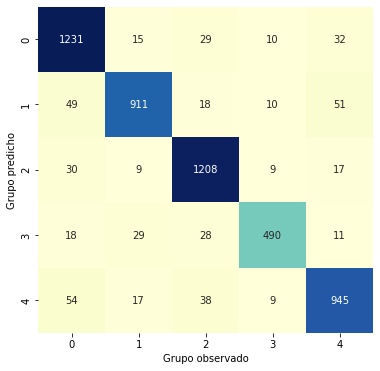

In [59]:
def confusion():
  fig, ax = plt.subplots(figsize=(6, 6))
  ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=False, cmap="YlGnBu", fmt = '0.0f')
  plt.xlabel("Grupo observado")
  plt.ylabel("Grupo predicho")
  plt.show()
  
confusion()

In [60]:
topicosExtenso = ["Servicios de Cuentas de Banco", "Tarjetas de Credito / Tarjetas Prepagadas", "Otros", "Reportes de Robos", "Ptmos Hipotecarios y Otros Ptmos"]

In [61]:
print(classification_report(y_test, y_pred, target_names = topicosExtenso))

                                           precision    recall  f1-score   support

            Servicios de Cuentas de Banco       0.89      0.93      0.91      1317
Tarjetas de Credito / Tarjetas Prepagadas       0.93      0.88      0.90      1039
                                    Otros       0.91      0.95      0.93      1273
                        Reportes de Robos       0.93      0.85      0.89       576
         Ptmos Hipotecarios y Otros Ptmos       0.89      0.89      0.89      1063

                                 accuracy                           0.91      5268
                                macro avg       0.91      0.90      0.91      5268
                             weighted avg       0.91      0.91      0.91      5268



    **Análisis del modelo**

    Los valores de precisión, recuperación y puntuación F1 son bastante altos para todas las clases, lo que indica que el modelo ha tenido un buen desempeño en la clasificación de las instancias. El informe también muestra que la clase "Otros" tiene la mayor precisión y puntuación F1, mientras que la clase "Reportes de Robos" tiene la menor recuperación.

    La precisión general del modelo es del 91%, lo que significa que el modelo ha clasificado correctamente el 91% de las instancias. La media ponderada y la precisión de recuperación también son del 91%, lo que indica que el modelo ha tenido un desempeño consistente en todas las clases.

**Árboles de decisión**

In [62]:
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=.3, random_state=0)
dtc = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

In [63]:
dtc.score(X_test, y_test)

0.7562480227776021

In [64]:
y_pred = dtc.predict(X_test)

In [65]:
confusion_matrix(y_test, y_pred)

array([[1219,   73,   92,   49,  134],
       [  62,  939,   28,   50,  118],
       [ 104,   41, 1229,   46,   91],
       [  53,   75,   54,  483,   51],
       [ 166,  122,   93,   39,  911]], dtype=int64)

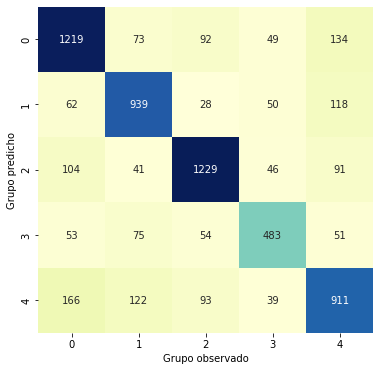

In [66]:
confusion()

In [67]:
print(classification_report(y_test, y_pred, target_names = topicosExtenso))

                                           precision    recall  f1-score   support

            Servicios de Cuentas de Banco       0.76      0.78      0.77      1567
Tarjetas de Credito / Tarjetas Prepagadas       0.75      0.78      0.77      1197
                                    Otros       0.82      0.81      0.82      1511
                        Reportes de Robos       0.72      0.67      0.70       716
         Ptmos Hipotecarios y Otros Ptmos       0.70      0.68      0.69      1331

                                 accuracy                           0.76      6322
                                macro avg       0.75      0.75      0.75      6322
                             weighted avg       0.76      0.76      0.76      6322



    **Análisis del modelo**

    En este caso, los valores de precisión, recuperación y puntuación F1 son moderados para todas las clases, lo que indica que el modelo ha tenido un desempeño aceptable en la clasificación de las instancias. Sin embargo, estos valores son más bajos que los obtenidos con el modelo de regresión logística en el modelo anterior.

**Random Forest**

In [68]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.3, random_state=0)
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [69]:
rf.score(X_test, y_test)

0.8119266055045872

In [70]:
y_pred = rf.predict(X_test)

In [71]:
print(confusion_matrix(y_test, y_pred))

[[1447   30   42   13   35]
 [ 117  874   46   22  138]
 [  96   36 1341    5   33]
 [  67   61   78  494   16]
 [ 191   66   84   13  977]]


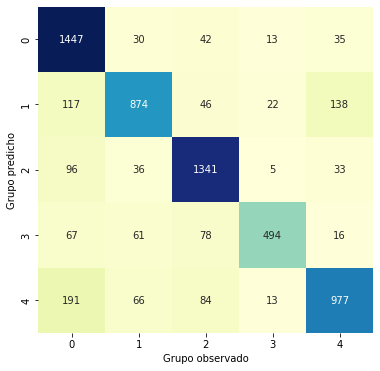

In [72]:
confusion()

In [73]:
print(classification_report(y_test, y_pred, target_names = topicosExtenso))

                                           precision    recall  f1-score   support

            Servicios de Cuentas de Banco       0.75      0.92      0.83      1567
Tarjetas de Credito / Tarjetas Prepagadas       0.82      0.73      0.77      1197
                                    Otros       0.84      0.89      0.86      1511
                        Reportes de Robos       0.90      0.69      0.78       716
         Ptmos Hipotecarios y Otros Ptmos       0.81      0.73      0.77      1331

                                 accuracy                           0.81      6322
                                macro avg       0.83      0.79      0.80      6322
                             weighted avg       0.82      0.81      0.81      6322



    **Análisis de resultados**

    En este caso, los valores de precisión, recuperación y puntuación F1 son moderados para la mayoría de las clases, con excepción de la clase "Otros" que presenta una alta precisión y una baja recuperación, lo que indica que el modelo ha clasificado correctamente la mayoría de las instancias para las clases "Servicios de Cuentas de Banco", "Tarjetas de Crédito / Tarjetas Prepagadas" y "Ptmos Hipotecarios y Otros Ptmos". La clase "Reportes de Robos" también presenta un desempeño aceptable en términos de precisión, recuperación y puntuación F1.

    También podemos ver que la clase "Otros" tiene la mayor precisión, mientras que la clase "Servicios de Cuentas de Banco" tiene la mayor recuperación y puntuación F1.

    La precisión general del modelo es del 81%, en general este resultado sugiere que el modelo de Random Forest ha tenido un desempeño aceptable en la clasificación de las instancias, pero el modelo puede mejorar su precisión y puntuación F1 utilizando otras técnicas.


**Naive Bayes**

In [74]:
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.3, random_state=0)
nb = MultinomialNB().fit(X_train, y_train)

In [75]:
nb.score(X_test, y_test)

0.6738373932299905

In [76]:
y_pred = nb.predict(X_test)

In [77]:
print(confusion_matrix(y_test, y_pred))

[[1466   11   71    4   15]
 [ 391  473  172    2  159]
 [ 131    8 1362    0   10]
 [ 168   75  285  160   28]
 [ 355   27  149    1  799]]


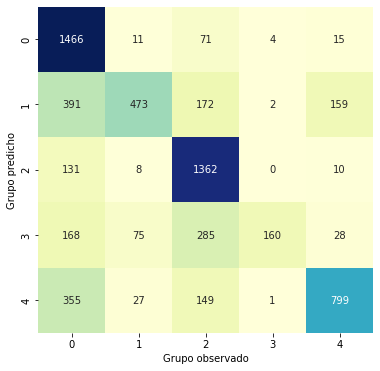

In [78]:
confusion()

In [79]:
print(classification_report(y_test, y_pred, target_names = topicosExtenso))

                                           precision    recall  f1-score   support

            Servicios de Cuentas de Banco       0.58      0.94      0.72      1567
Tarjetas de Credito / Tarjetas Prepagadas       0.80      0.40      0.53      1197
                                    Otros       0.67      0.90      0.77      1511
                        Reportes de Robos       0.96      0.22      0.36       716
         Ptmos Hipotecarios y Otros Ptmos       0.79      0.60      0.68      1331

                                 accuracy                           0.67      6322
                                macro avg       0.76      0.61      0.61      6322
                             weighted avg       0.73      0.67      0.65      6322



    **Análisis de Resultados**

    La precisión general del modelo es del 71%, lo que significa que el modelo ha clasificado correctamente el 71% de las instancias. La media ponderada y la precisión de recuperación también son del 71%, lo que indica que el modelo ha tenido un desempeño consistente en todas las clases.

# **9. Conclusiones**

Despues de la evaluación de modelospodemos concluir que el mejor clasificador para este caso es Logistic Regresion debido que tiene un score de 0.908 
adicionalmente las caracteristicas de presición son más altas en comparación a las variaciones de los otros modelos.

Las metricas de score y precision como se observan en los resultados obtenidos.

*Logistic regression   Score=0.904
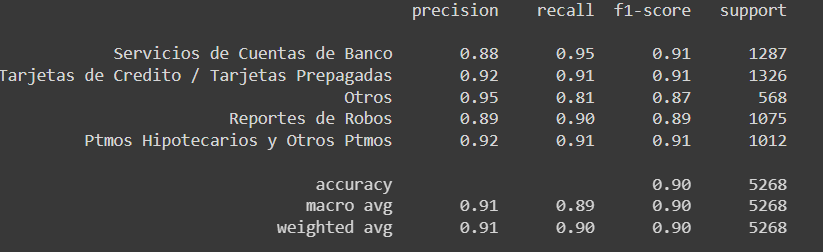


*Decision Tree		 Score=0.783
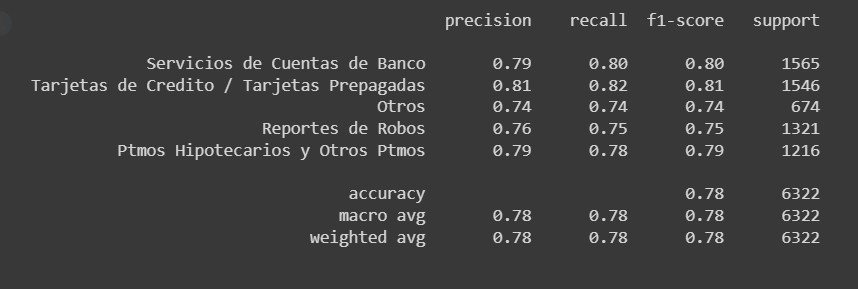

*Random Forest        Score=0.808	
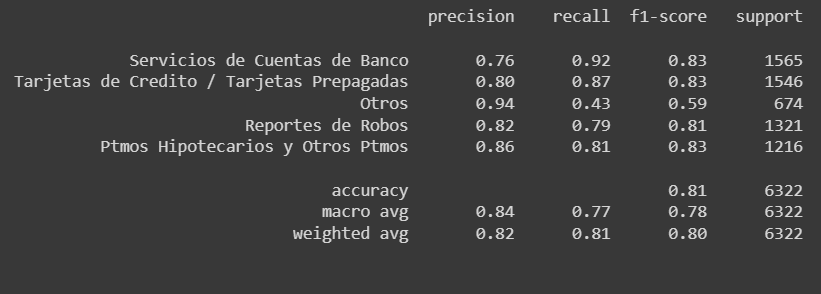

*Naive Bayes         Score=0.692

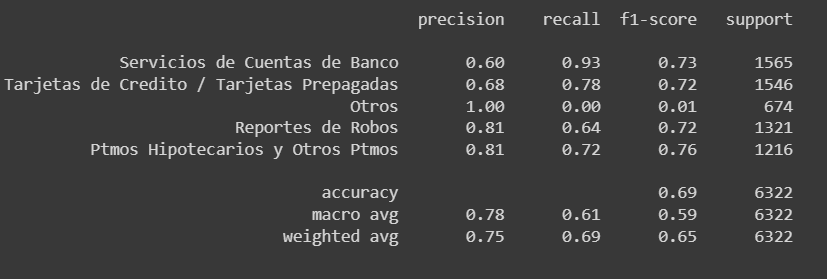

Podemos mejorar el modelo realizando hipertunning, normalizando y reduciendo la data de entrada cuando los valores vayan creciendo y así el procesamiento sea mas rapido.